In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.metrics import AUC
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import Sequence

In [2]:
train_labels_path = "retinal-disease-classification/Training_Set/RFMiD_Training_Labels.csv"
val_labels_path = "retinal-disease-classification/Evaluation_Set/RFMiD_Validation_Labels.csv"
test_labels_path = "retinal-disease-classification/Test_Set/RFMiD_Testing_Labels.csv"

# Load CSVs
train_labels = pd.read_csv(train_labels_path)
val_labels = pd.read_csv(val_labels_path)
test_labels = pd.read_csv(test_labels_path)

train_labels.head()


,ID,Disease_Risk,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,...,CME,PTCR,CF,VH,MCA,VS,BRAO,PLQ,HPED,CL
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Define selected diseases
selected_diseases = ['DR', 'MH', 'ODC', 'TSLN', 'DN', 'MYA', 'ARMD', 'BRVO', 'ODP', 'ODE', 'LS', 'RS', 'CSR', 'CRS']

train_labels_filtered = train_labels[['ID', 'Disease_Risk'] + selected_diseases]
val_labels_filtered = val_labels[['ID', 'Disease_Risk'] + selected_diseases]
test_labels_filtered = test_labels[['ID', 'Disease_Risk'] + selected_diseases]

# Update Disease_Risk to 1 only if at least one selected disease is present
def update_disease_risk(df, disease_columns):
    df.loc[:,'Disease_Risk'] = (df[disease_columns].sum(axis=1) > 0).astype(int)
    return df

train_labels_filtered = update_disease_risk(train_labels_filtered, selected_diseases)
val_labels_filtered = update_disease_risk(val_labels_filtered, selected_diseases)
test_labels_filtered = update_disease_risk(test_labels_filtered, selected_diseases)

print(train_labels_filtered.head())
print(train_labels_filtered["Disease_Risk"].value_counts())

   ID  Disease_Risk  DR  MH  ODC  TSLN  DN  MYA  ARMD  BRVO  ODP  ODE  LS  RS  \
0   1             1   1   0    0     1   0    0     0     0    0    0   0   0   
1   2             1   0   0    0     0   0    0     0     0    0    0   1   0   
2   3             1   0   0    0     0   0    0     0     0    0    0   1   0   
3   4             1   0   0    0     0   0    0     0     0    0    0   1   0   
4   5             1   0   0    0     0   0    0     0     0    0    0   1   0   

   CSR  CRS  
0    0    0  
1    0    0  
2    0    0  
3    0    0  
4    0    0  
Disease_Risk
1    1403
0     517
Name: count, dtype: int64


In [14]:
class DataGenerator(Sequence):
    def __init__(self, img_dir, labels_df, batch_size=32, img_size=(224, 224), shuffle=True, augment=False, augment_minority_class=False):
        self.img_dir = img_dir
        self.labels_df = labels_df
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.augment = augment
        self.augment_minority_class = augment_minority_class
        self.indices = np.arange(len(self.labels_df))
        self.datagen = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.15,
            zoom_range=0.15,
            horizontal_flip=True
        )
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.floor(len(self.labels_df) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_data = [self.labels_df.iloc[i] for i in batch_indices]
        X, y = self.__data_generation(batch_data)   
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __data_generation(self, batch_data):
        X = np.empty((self.batch_size, *self.img_size, 3))
        y = np.empty((self.batch_size, len(self.labels_df.columns) - 1), dtype=int)
        
        for i, data in enumerate(batch_data):
            img_name = str(data['ID']) + '.png'  # Access the filename from the 'ID' column
            img_path = os.path.join(self.img_dir, img_name)
            img = load_img(img_path, target_size=self.img_size)  # Load the image and resize it
            img = img_to_array(img) / 255.0  # Normalize the image pixels
            
            if self.augment:
                # Check for the minority class if true apply augmentation
                 if (self.augment_minority_class and data['Disease_Risk'] == 0) or not self.augment_minority_class:
                    img = self.datagen.random_transform(img)
            
            X[i,] = img  # Add the image to the batch
            y[i,] = data.iloc[1:].values  # Extract labels from the DataFrame
        
        return X, y

In [15]:
# Calculate class weights for `Disease_Risk` (0 = No Disease, 1 = Disease)
class_weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=train_labels_filtered['Disease_Risk'].values)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print("Class weights for Disease_Risk:", class_weight_dict)


Class weights for Disease_Risk: {0: 1.8568665377176015, 1: 0.684248039914469}


In [16]:
train_img_dir = "retinal-disease-classification\\Training_Set\\Training"
val_img_dir = "retinal-disease-classification\\Evaluation_Set\\Validation"
test_img_dir = "retinal-disease-classification\\Test_Set\\Test"

# Initialize data generators
train_generator = DataGenerator(
    img_dir=train_img_dir, 
    labels_df=train_labels_filtered, 
    batch_size=32, 
    shuffle=True,
    augment_minority_class=True)

val_generator = DataGenerator(
    img_dir=val_img_dir, 
    labels_df=val_labels_filtered, 
    batch_size=32, 
    shuffle=False,
    augment_minority_class=False)

test_generator = DataGenerator(
    img_dir=test_img_dir, 
    labels_df=test_labels_filtered, 
    batch_size=32, 
    shuffle=False,
    augment_minority_class=True)


In [21]:
# Load the EfficientNetB0 model
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True
for layer in base_model.layers[:-20]:  # Freeze all layers except the last 20
    layer.trainable = False

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.2),
    Dense(128, activation="relu"),
    Dropout(0.2),
    Dense(train_labels_filtered.shape[1] - 1, activation="sigmoid")  # One output per disease, using sigmoid for multi-label
])

# Compile the model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy", AUC(name="auc")])


In [22]:
early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_model.keras", monitor="val_loss", save_best_only=True)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8658 - auc: 0.7541 - loss: 0.3418

c:\Users\EliteBook\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


60/60 ━━━━━━━━━━━━━━━━━━━━ 421s 7s/step - accuracy: 0.8673 - auc: 0.7546 - loss: 0.3409 - val_accuracy: 1.0000 - val_auc: 0.8210 - val_loss: 0.2727
Epoch 2/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 376s 6s/step - accuracy: 0.9969 - auc: 0.8139 - loss: 0.2648 - val_accuracy: 1.0000 - val_auc: 0.8251 - val_loss: 0.2574
Epoch 3/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 417s 7s/step - accuracy: 0.9978 - auc: 0.8135 - loss: 0.2668 - val_accuracy: 1.0000 - val_auc: 0.8267 - val_loss: 0.2554
Epoch 4/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 347s 6s/step - accuracy: 1.0000 - auc: 0.8227 - loss: 0.2567 - val_accuracy: 1.0000 - val_auc: 0.8278 - val_loss: 0.2581
Epoch 5/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 336s 6s/step - accuracy: 1.0000 - auc: 0.8237 - loss: 0.2586 - val_accuracy: 1.0000 - val_auc: 0.8266 - val_loss: 0.2564
Epoch 6/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 437s 7s/step - accuracy: 1.0000 - auc: 0.8240 - loss: 0.2584 - val_accuracy: 1.0000 - val_auc: 0.8266 - val_loss: 0.2543
Epoch 7/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 667s 11s/step - acc

In [23]:
from sklearn.metrics import classification_report, roc_auc_score

# Predict on the test set
y_true = np.array([y for _, y in test_generator])
y_pred = model.predict(test_generator)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Flatten predictions and true labels for calculating overall performance metrics
y_true_flat = y_true.reshape(-1, y_true.shape[-1])
y_pred_flat = y_pred.reshape(-1, y_pred.shape[-1])

# Classification Report
print("Classification Report:\n")
print(classification_report(y_true_flat, y_pred_flat, target_names=selected_diseases, zero_division=1))

# AUC Score (per disease)
try:
    auc_score = roc_auc_score(y_true_flat, y_pred_flat, average="macro")
    print(f"Overall AUC Score: {auc_score:.4f}")
except ValueError as e:
    print(f"Error calculating AUC: {e}")

MemoryError: Unable to allocate 36.8 MiB for an array with shape (32, 224, 224, 3) and data type float64

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 953ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 978ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 959ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 971ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 946ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 935ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 917ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 918ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 971ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 947ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 877ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


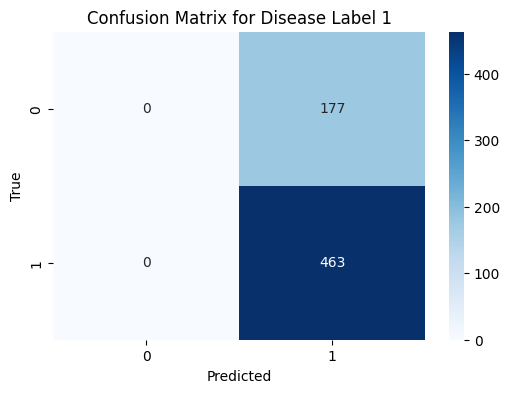

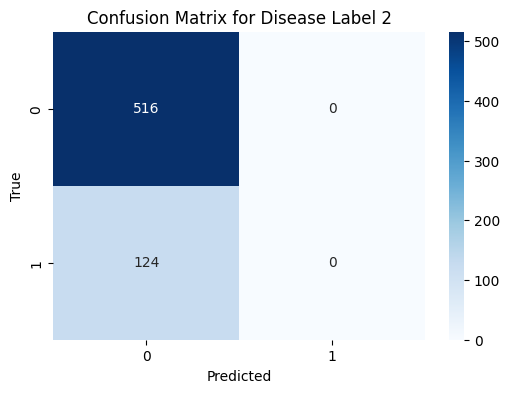

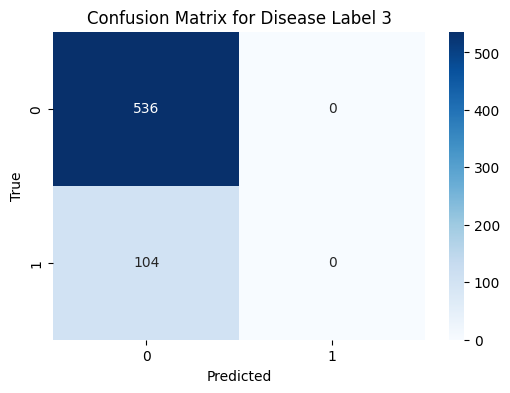

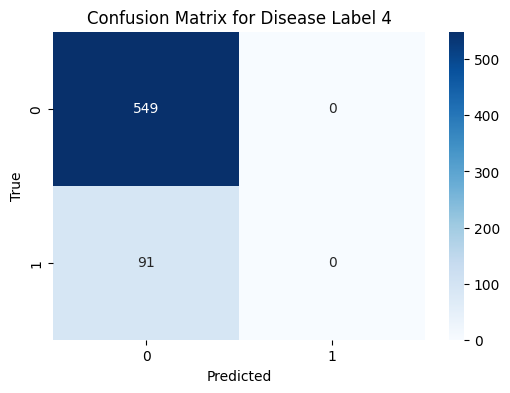

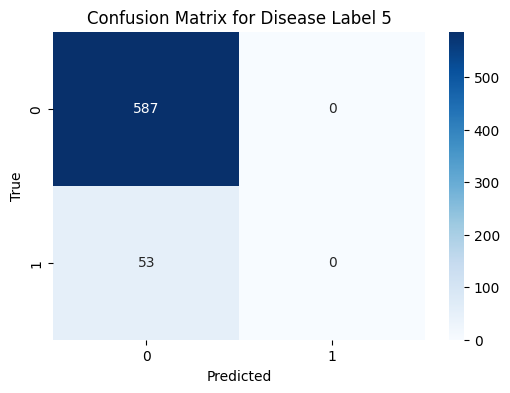

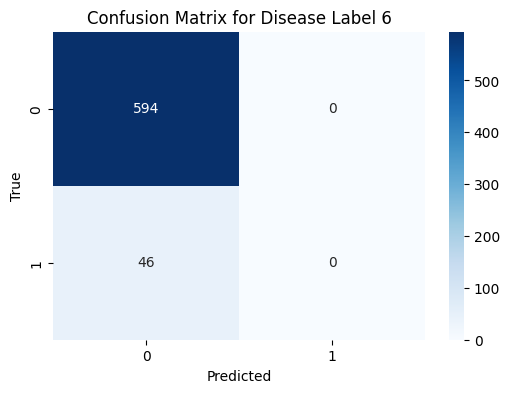

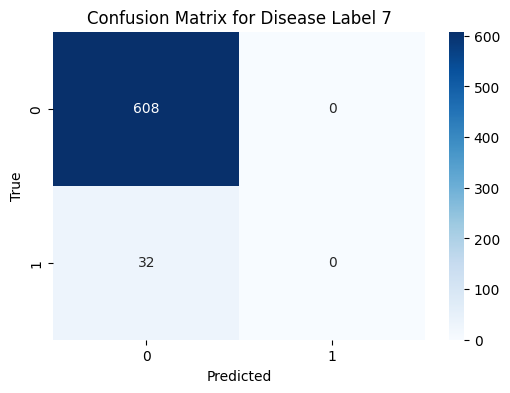

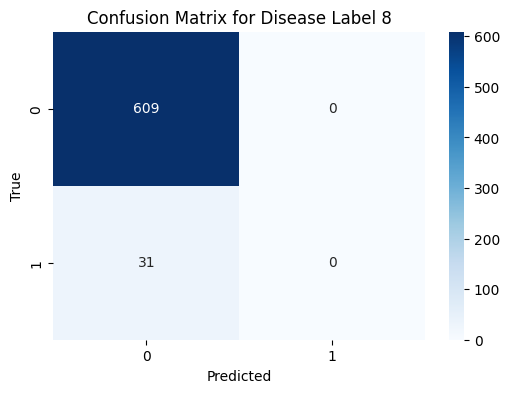

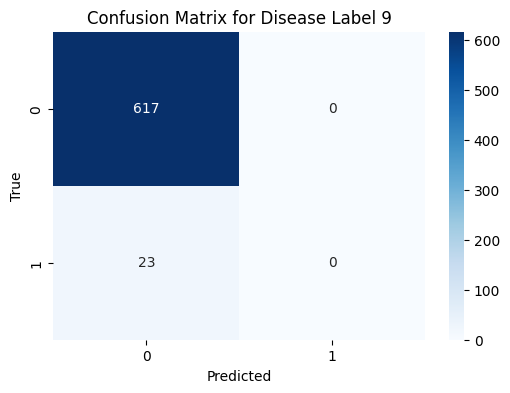

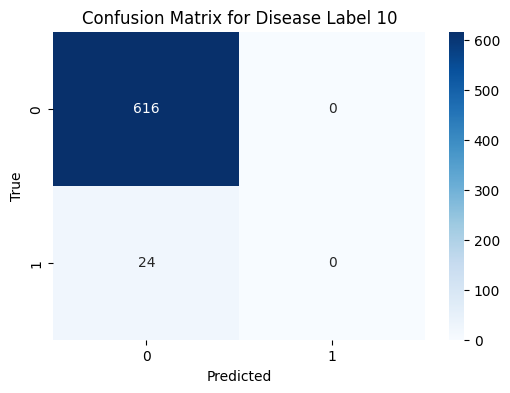

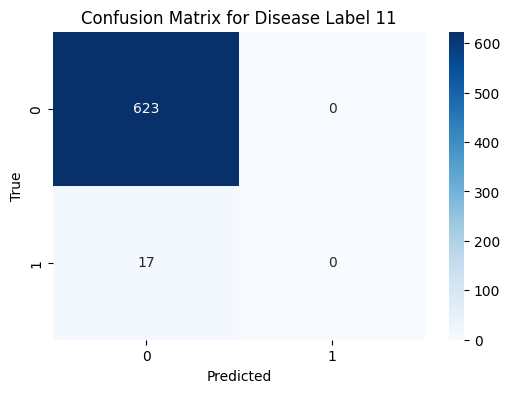

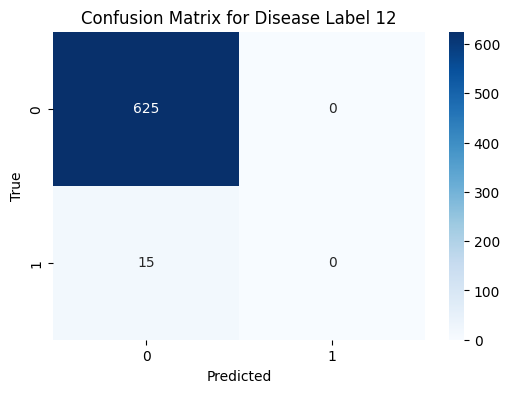

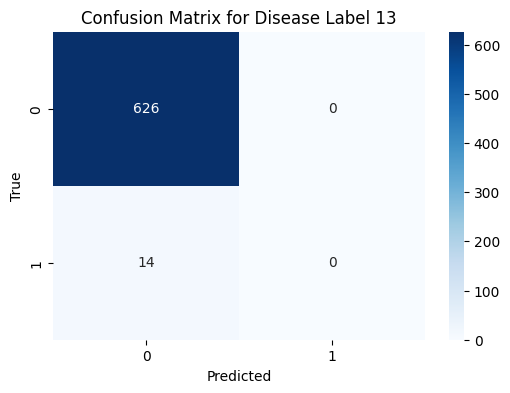

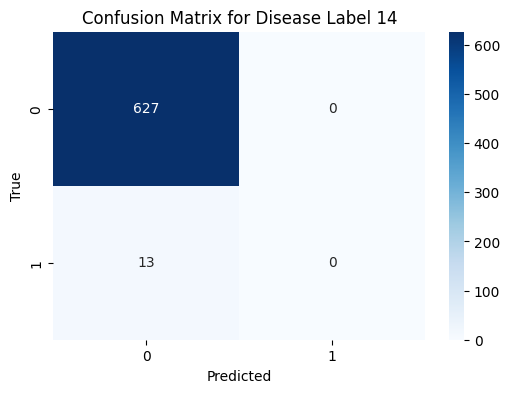

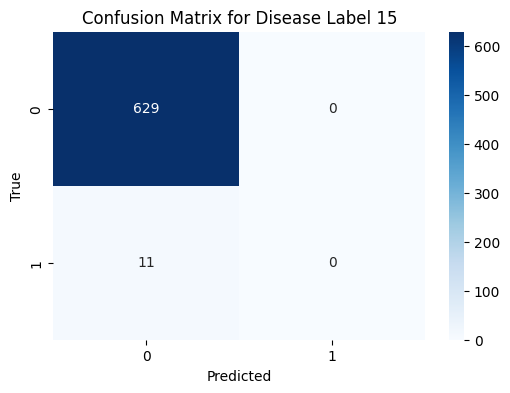

In [24]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get all true labels and predictions from the generator
y_true = []
y_pred = []

for i in range(len(test_generator)):
    X_batch, y_batch = test_generator[i]
    y_true.append(y_batch)
    y_pred.append(model.predict(X_batch))

# Convert lists to numpy arrays
y_true = np.vstack(y_true)
y_pred = np.vstack(y_pred)

# Convert probabilities to binary predictions (1 if prob >= 0.5, else 0)
y_pred_binary = (y_pred >= 0.5).astype(int)

# Calculate confusion matrix for each label
for i in range(y_true.shape[1]):
    cm = confusion_matrix(y_true[:, i], y_pred_binary[:, i])
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix for Disease Label {i+1}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

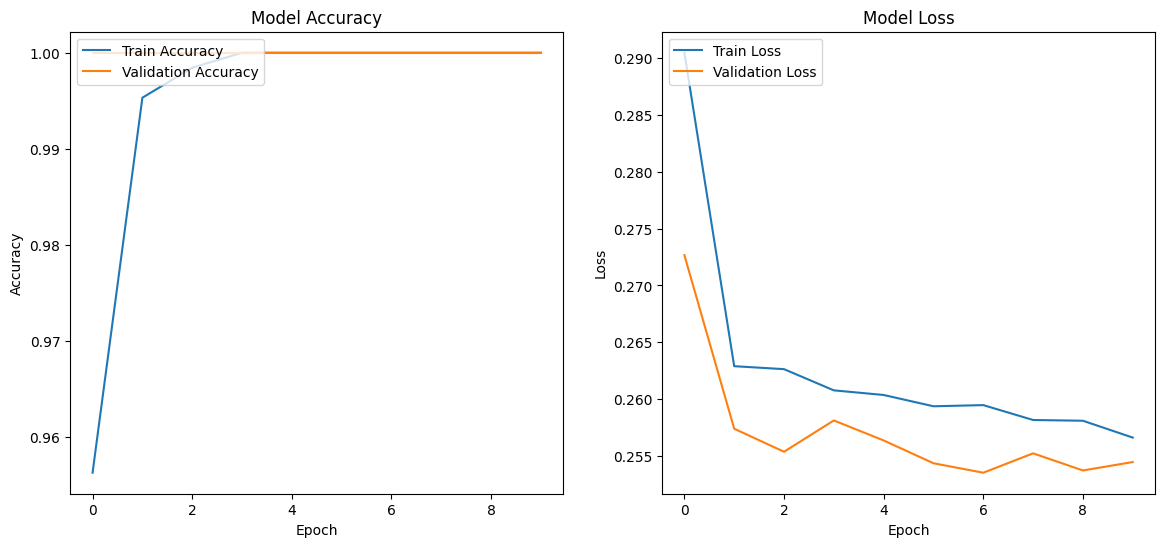

In [25]:
import matplotlib.pyplot as plt

def plot_training_curves(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(14, 6))
    
    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper left')
    
    plt.show()

# Call the function with your model history
plot_training_curves(history)

In [26]:
from sklearn.metrics import multilabel_confusion_matrix, classification_report

# Predict on the test set
y_true = np.array([y for _, y in test_generator])
y_pred = model.predict(test_generator)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Flatten to 2D arrays if needed
y_true = y_true.reshape(-1, y_true.shape[-1])
y_pred = y_pred.reshape(-1, y_pred.shape[-1])

# Get confusion matrix for each label (disease)
conf_matrices = multilabel_confusion_matrix(y_true, y_pred)

# Plot each confusion matrix
for i, disease in enumerate(selected_diseases):
    plt.figure(figsize=(5, 5))
    plt.imshow(conf_matrices[i], interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {disease}')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['No', 'Yes'], rotation=45)
    plt.yticks(tick_marks, ['No', 'Yes'])
    
    thresh = conf_matrices[i].max() / 2.
    for j, k in np.ndindex(conf_matrices[i].shape):
        plt.text(k, j, f"{conf_matrices[i][j, k]}", ha="center", 
                 color="white" if conf_matrices[i][j, k] > thresh else "black")
        
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

MemoryError: Unable to allocate 36.8 MiB for an array with shape (32, 224, 224, 3) and data type float64

In [27]:
# Flatten and binarize outputs for the report
y_true_flat = y_true.flatten()
y_pred_flat = y_pred.flatten()

# Generate the classification report
print(classification_report(y_true_flat, y_pred_flat, target_names=selected_diseases, zero_division=1))

ValueError: Classification metrics can't handle a mix of binary and continuous targets

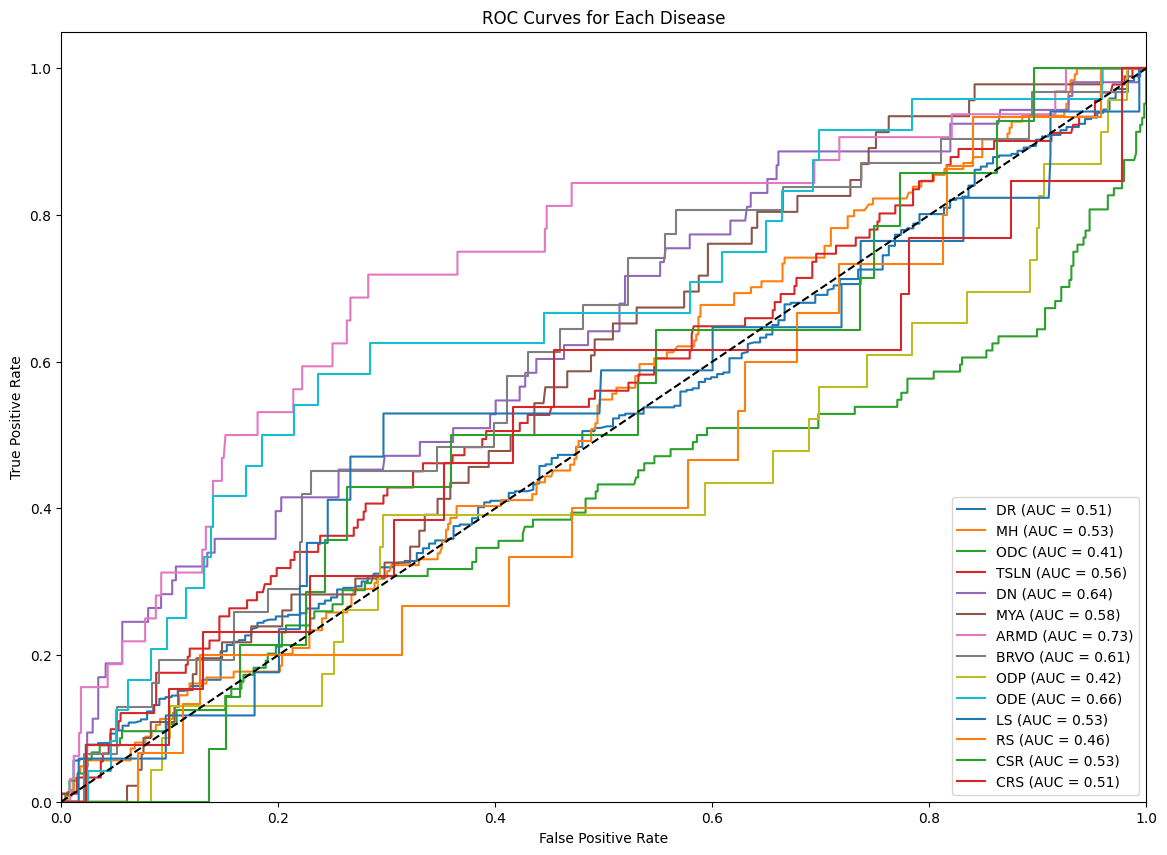

In [28]:
from sklearn.metrics import roc_curve, auc

# Plot ROC curve for each disease
plt.figure(figsize=(14, 10))
for i, disease in enumerate(selected_diseases):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{disease} (AUC = {roc_auc:.2f})')
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Disease')
plt.legend(loc="lower right")
plt.show()

In [29]:
model.save("retinal_disease_classifier.keras")